In [1]:
'''
author: Felix Hol
date: 2019 July 22
content: code to track mosquitoes, several filtering parameters will need tweaking depending on imaging parameters.
'''

import numpy as np
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') ### this is a workaround for a bug when running on macOS, may not be necessary anymore
import matplotlib.pyplot as plt
import os
import itertools as it
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import skimage
from skimage import data, io, util
from skimage.feature import (canny, match_descriptors, peak_local_max, match_template, corner_peaks, corner_harris, plot_matches, BRIEF)
from skimage.color import rgb2gray
from skimage.draw import circle
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
from scipy import ndimage as ndi
import scipy
import trackpy as tp
import pylab
import math
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from tqdm import tnrange
import pickle
import glob

In [17]:
dataDir = '/Volumes/Fe_ssd02/bloodTaste/190702_SalineNoATP/M2/'
saveDir = '/Users/felix/Documents/mosquitoes/mosquitoData/bloodTasteData/analysis/190702_SalineNoATP_M2/'
frames = pims.ImageSequence(dataDir+'/*.tiff', as_grey=True)

In [3]:
len(frames)

10145

In [4]:
####create background image

start = 1
stop = len(frames) - 1
step = math.floor(len(frames)/20)

numBGframes = int(np.ceil((stop - start) /step) + 1)
frameSize = frames[1].shape
BG = np.zeros([frameSize[0], frameSize[1], numBGframes])

j = 1
for i in range(start, stop, step):
    j += 1
    BG[:, :, j - 1] = np.invert(frames[i])    

BG = np.median(BG, axis=2)

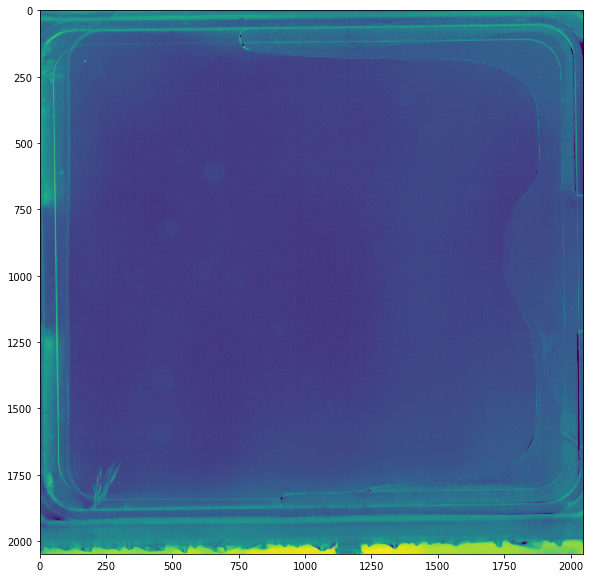

In [5]:
plt.figure(figsize=(25,10))
plt.imshow(BG)

In [6]:
#### get centroid coordinates

def trackMosq2(i):
    borderToExclude = 50
    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 80
    Bts = remove_small_objects(Bt, min_size=400)
    Be = erosion(Bts, selem2)
    Bf = remove_small_objects(Be, min_size=300)
    Bc = binary_closing(Bf, selem1)
    C = B * Bc
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    eroded[eroded < 0] = 0
    erL = label(eroded>0)
    erR = regionprops(erL, C)#, coordinates='xy')
    l = 1
    for props in erR:
        if props.area > 100000:
            erL[erL==l] = 0
        if props.major_axis_length > 1000:
            erL[erL==l] = 0
        if props.centroid[0] < borderToExclude or props.centroid[1] < borderToExclude or props.centroid[0] > frameSize[0] - borderToExclude or props.centroid[1] > frameSize[1] - borderToExclude:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        numCent += 1
#     coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
#     cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
#     frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
#     frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
#     coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
#     coordinatesF = np.hstack((coordinates,frameNoA))
#     numCoords = coordinatesF.shape[0]
    numCents = centroidsF.shape[0]
    return centroidsF, numCents

#     return centroidsF, coordinatesF, numCents, numCoords


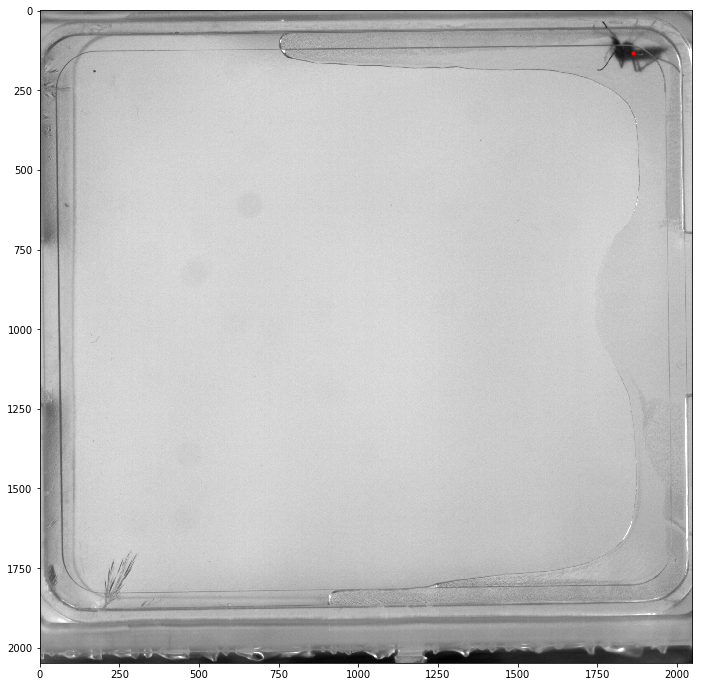

In [10]:
#####testing....
i = 4700
centroidsF, numCents = trackMosq2(i)
plt.figure(figsize=(18,12))
plt.imshow(frames[i], cmap = 'gray')
# plt.imshow(eroded)
# plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsF[:,1],centroidsF[:,0],'r.')

In [11]:
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(trackMosq2)(i) for i in tnrange(1000, 9600))

In [12]:
centroidsAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))

In [13]:
len(centroidsAllT)

3790

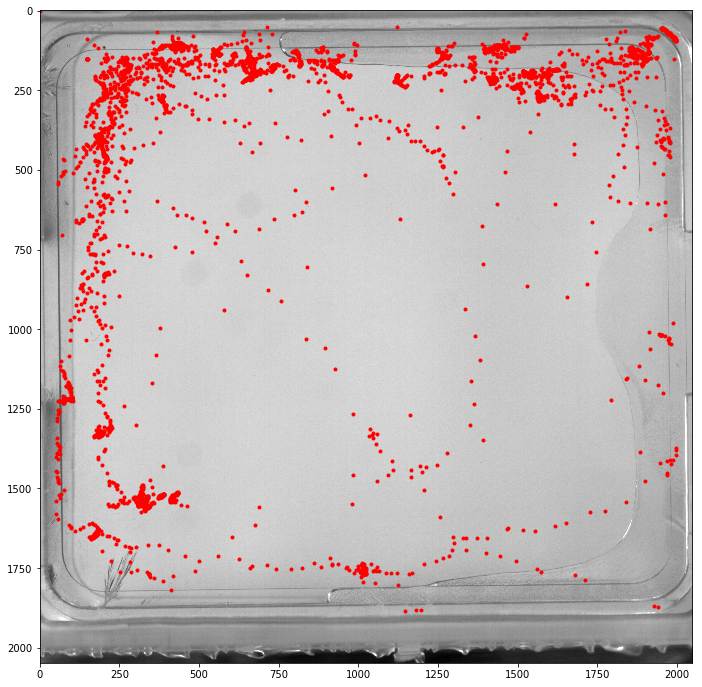

In [14]:
plt.figure(figsize=(18,12))
plt.imshow(frames[1000], cmap = 'gray')
# plt.imshow(eroded)
# plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'r.')

In [15]:
os.chdir(saveDir)
with open('190702_SalineNoATP_M2_ROICent.pkl', 'wb') as f:
    pickle.dump(centroidsAllT, f)

In [ ]:
# os.chdir(saveDir)
# with open('190625_KPPTN_01_Cent.pkl', 'rb') as f:
#     centroidsAllT = pickle.load(f)

In [ ]:
# os.chdir(saveDir)
# with open('190625_KPPTN_01_tracks.pkl', 'rb') as f:
#     t = pickle.load(f)

In [ ]:
os.chdir(saveDir)
pickleList = glob.glob('*.pkl')
centroidsAllCat = np.zeros((1,3))

for i in pickleList:
    with open(i, "rb") as input_file:
        centroidsI = pickle.load(input_file)
    centroidsAllCat = np.vstack((centroidsAllCat, centroidsI))

In [18]:
df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

,y,x,frame
0,0.000000,0.000000,0.0
1,138.367103,502.370428,1169.0
2,564.702354,280.901415,1172.0
3,996.416232,378.700806,1173.0
4,1299.368127,303.702693,1174.0


In [19]:
t = tp.link_df(df_cenAllT, 700, memory=4)

Frame 9513: 1 trajectories present


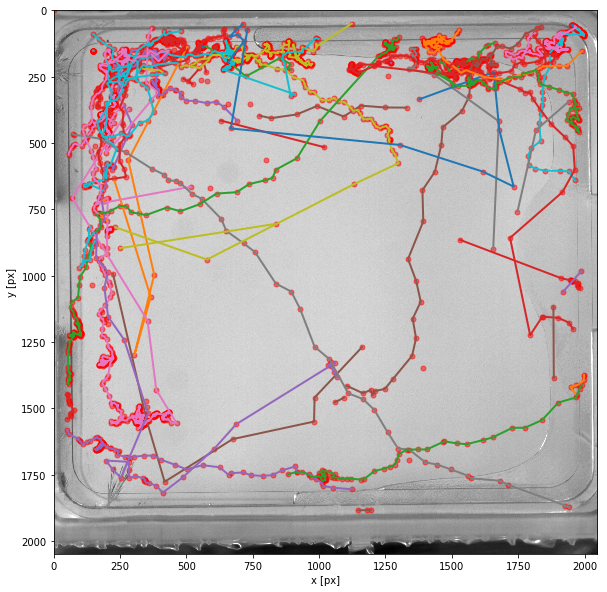

In [20]:
plt.figure(figsize=(25,10))
plt.imshow(frames[200], cmap='gray')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'r.',alpha=0.5, markersize=10)
tp.plot_traj(t, plot_style={'linewidth':'2.0'})

In [21]:
os.chdir(saveDir)
t.to_pickle('190702_SalineNoATP_M2_ROItracks.pkl')

In [ ]:
# os.chdir(saveDir)
# t = pickle.load(open('190625_KPPTN_01_tracks.pkl', 'rb'))

In [22]:
t.head()

,y,x,frame,particle
0,0.000000,0.000000,0.0,0.0
1,138.367103,502.370428,1169.0,1.0
2,564.702354,280.901415,1172.0,1.0
3,996.416232,378.700806,1173.0,1.0
4,1299.368127,303.702693,1174.0,1.0


In [23]:
tFilt = tp.filter_stubs(t, 10)
tFilt.particle.unique()

array([ 6., 13., 14., 15., 16., 17., 19., 20., 21., 23., 24., 25., 28.,
       29., 32., 33., 34., 36., 37., 38., 39., 42., 43., 49., 50., 52.,
       53., 56., 57., 59., 61., 62., 63.])

In [24]:
len(tFilt)

3703

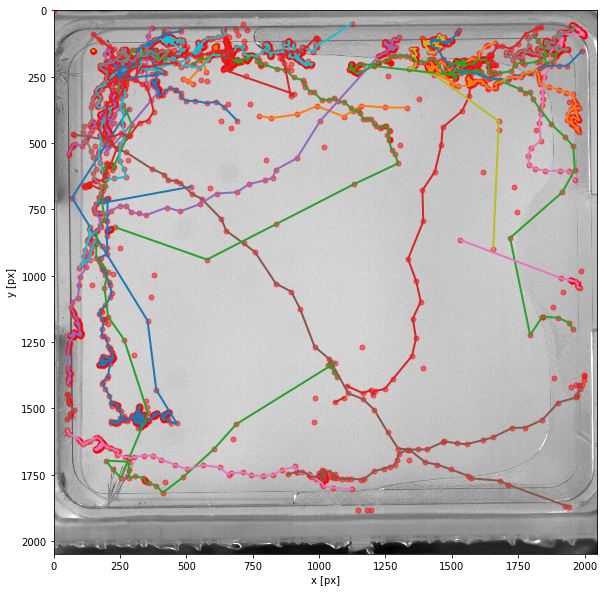

In [25]:
plt.figure(figsize=(25,10))
plt.imshow(frames[200], cmap='gray')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'r.',alpha=0.5, markersize=10)
tp.plot_traj(tFilt, plot_style={'linewidth':'2.0'})

In [ ]:
len(tFilt.particle.unique())

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[50], cmap='gray')
tp.plot_traj(tFilt.loc[tFilt['particle'] == 17.0], plot_style={'linewidth':'3.0'})

In [ ]:
p114 = tFilt.loc[tFilt['particle'] == 114.0]

In [ ]:
p049 = tFilt.loc[tFilt['particle'] == 49.0]
p125 = tFilt.loc[tFilt['particle'] == 125.0]

In [ ]:
p114.head()

In [ ]:
A = np.zeros(frameSize)
A = A + np.invert(frames[4381])
B = A - BG
B[B < 0] = 0
# if B.min() > 0:
#     Bm = B - B.min()
# else:
#     Bm = B

plt.figure(figsize=(25,25))
plt.imshow(np.invert(B.astype(int)), cmap='gray')

In [ ]:
np.min(np.invert(B.astype(int)))

In [ ]:
np.max(B)

In [ ]:

A = np.zeros(frameSize)
A = A + np.invert(frames[4381])
B = A - BG
B[B < 0] = 0
# if B.min() > 0:
#     Bm = B - B.min()
# else:
#     Bm = B

plt.figure(figsize=(25,25))
plt.imshow(np.invert(B.astype(int)), cmap='gray', vmin=25, vmax=95)

In [ ]:
plt.figure(figsize=(25,25))

alphas = [1, 0.5, 0.35, 0.25]

j = 0

for i in [3194, 3312, 4675, 5767]:
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    B[B < 0] = 0
    plt.imshow(np.invert(B.astype(int)), cmap='gray', alpha=alphas[j], vmin=-40, vmax=-3)
    j = j + 1
    
plt.savefig('190625_KPTTN_p049_114_125_NOtracks05.png')

In [ ]:
plt.figure(figsize=(25,25))

alphas = [1, 0.75, 0.65, 0.55]

j = 0

for i in [3194, 3312, 4675, 5767]:
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    B[B < 0] = 0
    plt.imshow(np.invert(B.astype(int)), cmap='gray', alpha=alphas[j], vmin=-40, vmax=-3)
    j = j + 1

for i in range(1, len(p114) - 2):
    d = math.sqrt((p114.iloc[i + 1].x - p114.iloc[i].x) ** 2 + (p114.iloc[i + 1].y - p114.iloc[i].y) ** 2)
    plt.plot(p114.iloc[i:i+2].x, p114.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
for i in range(1, len(p049) - 2):
    d = math.sqrt((p049.iloc[i + 1].x - p049.iloc[i].x) ** 2 + (p049.iloc[i + 1].y - p049.iloc[i].y) ** 2)
    plt.plot(p049.iloc[i:i+2].x, p049.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
for i in range(1, len(p125) - 2):
    d = math.sqrt((p125.iloc[i + 1].x - p125.iloc[i].x) ** 2 + (p125.iloc[i + 1].y - p125.iloc[i].y) ** 2)
    plt.plot(p125.iloc[i:i+2].x, p125.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
plt.savefig('190625_KPTTN_p049_114_125_tracks05.pdf')

In [ ]:
os.getcwd()

In [ ]:
plt.figure(figsize=(25,25))
plt.imshow(frames[3194], cmap='gray', vmin=125, vmax=155, alpha=1)
plt.imshow(frames[3312], cmap='gray', vmin=125, vmax=155, alpha=0.5)
plt.imshow(frames[5100], cmap='gray', vmin=125, vmax=155, alpha=0.4)
# plt.imshow(frames[2591], cmap='gray', vmin=55, vmax=160, alpha=0.4)
# plt.imshow(frames[5571], cmap='gray', vmin=55, vmax=160, alpha=0.4)
# plt.imshow(frames[3195], cmap='gray', vmin=55, vmax=180, alpha=0.4)

# plt.imshow(frames[4327], cmap='gray', vmin=95, vmax=180, alpha=1)
# plt.imshow(frames[4411], cmap='gray', vmin=95, vmax=180, alpha=0.5)
# plt.imshow(frames[5148], cmap='gray', vmin=55, vmax=180, alpha=0.4)

# for i in range(1, len(p114) - 2):
#     d = math.sqrt((p114.iloc[i + 1].x - p114.iloc[i].x) ** 2 + (p114.iloc[i + 1].y - p114.iloc[i].y) ** 2)
#     plt.plot(p114.iloc[i:i+2].x, p114.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
# for i in range(1, len(p049) - 2):
#     d = math.sqrt((p049.iloc[i + 1].x - p049.iloc[i].x) ** 2 + (p049.iloc[i + 1].y - p049.iloc[i].y) ** 2)
#     plt.plot(p049.iloc[i:i+2].x, p049.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
# for i in range(1, len(p125) - 2):
#     d = math.sqrt((p125.iloc[i + 1].x - p125.iloc[i].x) ** 2 + (p125.iloc[i + 1].y - p125.iloc[i].y) ** 2)
#     plt.plot(p125.iloc[i:i+2].x, p125.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)

In [ ]:
p114.iloc[0:2].x

In [ ]:
d = math.sqrt((p114.iloc[1].x - p114.iloc[0].x) ** 2 + (p114.iloc[1].y - p114.iloc[0].y) ** 2)
d

In [ ]:
(p114.iloc[1].x - p114.iloc[0].x) ** 2

In [ ]:
trajLen = np.empty([0, 0])

for i in t.particle.unique():
    trajLen = np.append(trajLen, len(tFilt.loc[tFilt['particle'] == i]))
    

In [ ]:
trajLen

In [ ]:
def cropMos(p, t):
    
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2
    
    tP = t.loc[t['particle'] == p]
    for index, row in tP.iterrows():
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
        skimage.io.imsave("crop_p" + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png", currROI)


In [ ]:
t.head()

In [ ]:
os.chdir('/Volumes/Samsung_T5/Felix/biteData_sam/albopictus/190607_01/190607_albo_crops/')
cropMos(i, t)

In [ ]:
os.chdir('/Users/felix/Documents/mosquitoes/mosquitoData/biteData/albopictus/190625_albopictus_crops/')
mosToCrop = tFilt.particle.unique()

num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(cropMos)(i, t) for i in mosToCrop)

In [ ]:
os.chdir('/Users/felix/Documents/mosquitoes/mosquitoData/bloodTasteMovies/analysis/190703_SalineYesATP_M10_crops/')
mosToCrop = tFilt.particle.unique()
for i in mosToCrop:
    print(i)
    print(os.getcwd())
    cropMos(i, t)

In [ ]:
mosToCrop = t.particle.unique()
mosToCrop

In [ ]:
os.chdir('/Volumes/Samsung_T5/Felix/biteData_sam/albopictus/190607_01/190607_albo_crops/')

mosToCrop = t.particle.unique()
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(cropMos)(i, t) for i in mosToCrop)

In [ ]:
i = 375

features = pd.DataFrame()

selem1 = disk(8)
selem2 = disk(1)
A = np.zeros(frameSize)
A = A + np.invert(frames[i])
B = A - BG
if B.min() > 0:
    Bm = B - B.min()
else:
    Bm = B
Bt = Bm > 70
Be = erosion(Bt, disk(3))
Bts = remove_small_objects(Be, min_size=300)
# Be = erosion(Bts, selem2)
# Bf = remove_small_objects(Be, min_size=200)
Bc = binary_closing(Bts, disk(15))
Bc2 = scipy.ndimage.morphology.binary_fill_holes(Bc)
Bce = erosion(Bc2, disk(3))
C = B * Bce
# eroded = erosion(C, selem2)
# eroded = skimage.filters.gaussian(C, 4)
# eroded[eroded < 0] = 0
erL = label(C>0)
erR = regionprops(erL)#, C)#, coordinates='xy')
l = 1
for props in erR:
    if props.area > 100000:
        erL[erL==l] = 0
    if props.major_axis_length > 1000:
        erL[erL==l] = 0
    l = l +1
erLf = label(erL>0)
# erodedF = eroded * (erLf > 0)
erRf = regionprops(erLf)#, C)#, coordinates='xy')
centroids = np.zeros([len(erRf), 2])
numCent = 0
for props in erRf:
    centroids[numCent] = props.centroid
    features = features.append([{'y': props.centroid[0], 
                                 'x': props.centroid[1], 
                                 'frame': i, 
                                 'area': props.filled_area},])
    numCent += 1
coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
cS= coordinates.shape; numCoor = cS[0]
cenS= centroids.shape; numCen = cenS[0]
frameNo = i
frameNoA = np.zeros((numCoor,1), dtype=np.int)
frameNoCen = np.zeros((numCen,1), dtype=np.int)
frameNoA[:] = frameNo
frameNoCen[:] = frameNo
coordinatesF = np.hstack((coordinates,frameNoA))
centroidsF = np.hstack((centroids,frameNoCen))
coordinatesF = np.hstack((coordinates,frameNoA))
numCoords = coordinatesF.shape[0]
numCents = centroidsF.shape[0]

In [ ]:
plt.figure(figsize=(20,18))
# Bc3 = erosion(Bc, disk(3))
plt.imshow(C)

In [ ]:
plt.figure(figsize=(20,18))
# Bc3 = erosion(Bc, disk(3))
plt.imshow(B)

In [ ]:
def mosFeat01(i):

    features = pd.DataFrame()

    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 35
    Be = erosion(Bt, disk(3))
    Bts = remove_small_objects(Be, min_size=300)
    # Be = erosion(Bts, selem2)
    # Bf = remove_small_objects(Be, min_size=200)
    Bc = binary_closing(Bts, disk(15))
    Bc2 = scipy.ndimage.morphology.binary_fill_holes(Bc)
    Bce = erosion(Bc2, disk(3))
    C = B * Bce
    # eroded = erosion(C, selem2)
    # eroded = skimage.filters.gaussian(C, 4)
    # eroded[eroded < 0] = 0
    erL = label(C>0)
    erR = regionprops(erL)#, C)#, coordinates='xy')
    l = 1
    for props in erR:
        if props.area > 100000:
            erL[erL==l] = 0
        if props.major_axis_length > 1000:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    # erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf)#, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        features = features.append([{'y': props.centroid[0], 
                                     'x': props.centroid[1], 
                                     'frame': i, 
                                     'area': props.filled_area},])
        numCent += 1
    coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
    cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
    coordinatesF = np.hstack((coordinates,frameNoA))
    numCoords = coordinatesF.shape[0]
    numCents = centroidsF.shape[0]
    return centroidsF, coordinatesF, features

In [ ]:
#####testing....
i = 1120
centroidsF, coordinatesF, features = mosFeat01(i)
plt.figure(figsize=(15,10))
plt.imshow(frames[i], cmap = 'gray')
# plt.imshow(eroded)
plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsF[:,1],centroidsF[:,0],'b.')

In [ ]:
plt.figure(figsize=(25,20))
# Bc3 = erosion(Bc, disk(3))
plt.imshow(B)

In [ ]:
features = pd.DataFrame()

for i in range(3800,4800,5):
    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 35
    Be = erosion(Bt, disk(3))
    Bts = remove_small_objects(Be, min_size=300)
    # Be = erosion(Bts, selem2)
    # Bf = remove_small_objects(Be, min_size=200)
    Bc = binary_closing(Bts, disk(15))
    Bc2 = scipy.ndimage.morphology.binary_fill_holes(Bc)
    Bce = erosion(Bc2, disk(3))
    C = B * Bce
    # eroded = erosion(C, selem2)
    # eroded = skimage.filters.gaussian(C, 4)
    # eroded[eroded < 0] = 0
    erL = label(C>0)
    erR = regionprops(erL)#, C)#, coordinates='xy')
    l = 1
    for props in erR:
        if props.area < 1000:
            erL[erL==l] = 0
        if props.area > 100000:
            erL[erL==l] = 0
        if props.major_axis_length > 1000:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    # erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf)#, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        features = features.append([{'y': props.centroid[0], 
                                     'x': props.centroid[1], 
                                     'frame': i, 
                                     'area': props.filled_area},])
        numCent += 1
    coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
    cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
    coordinatesF = np.hstack((coordinates,frameNoA))
    numCoords = coordinatesF.shape[0]
    numCents = centroidsF.shape[0]

In [ ]:
features.head(5)

In [ ]:
features.to_pickle(saveDir + '/181206_01_frame3800-4800_every5.pkl')

In [ ]:
plt.plot(t[t.particle == 0.0].frame, t[t.particle == 0.0].area.rolling(window=20).mean())
# plt.plot(t[t.particle == 4.0].frame, t[t.particle == 4.0].area)
# plt.plot(t[t.particle == 2.0].frame, t[t.particle == 2.0].area)
# plt.plot(t[t.particle == 3.0].area)

In [ ]:
# plt.figure(figsize=(20,20))
search_range = 500
t = tp.link_df(features, search_range, memory=30)
# plt.imshow(B)
# tp.plot_traj(t, plot_style={'linewidth':'3.0'})

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(B)
tp.plot_traj(t, plot_style={'linewidth':'3.0'})

In [ ]:
len(tF)

In [ ]:
tF = tp.filter_stubs(t, 1)
allMosF = tF.particle.unique()

plt.figure(figsize=(15,10))

# for i in range(0, len(allMos) - 1):
#     plt.plot(tF[tF.particle == allMos[i]].frame, tF[tF.particle == allMos[i]].area)
    
for i in range(0, len(allMos) - 1):
    plt.plot(tF[tF.particle == allMos[i]].frame, tF[tF.particle == allMos[i]].area.rolling(window=2).mean() - tF[tF.particle == allMos[i]].area.min())
    
# for i in range(0, len(allMos) - 1):
#     plt.plot(tF[tF.particle == allMos[i]].frame[0:-1], np.diff(tF[tF.particle == allMos[i]].area))

In [ ]:
Be2 = erosion(Bt, disk(5))
Bf = remove_small_objects(Be2, min_size=200)
Bc2 = binary_closing(Bf, disk(15))
plt.figure(figsize=(25,20))
Bc3 = scipy.ndimage.morphology.binary_fill_holes(Bc2)
plt.imshow(Bc2)

In [ ]:
plt.figure(figsize=(25,20))
# Bcc = binary_closing(Bf, disk(12))
plt.imshow(B)

In [ ]:
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(trackMosq2)(i) for i in tnrange(1, 500))

In [ ]:
centroidsAllT = np.zeros((1,3))
coordinatesAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))
    coordinatesAllT = np.vstack((coordinatesAllT,results[i][1]))

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[2000], cmap = 'gray')
plt.plot(coordinatesAllT[:,1],coordinatesAllT[:,0],'r.')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'b.')

In [ ]:
os.chdir(saveDir)
with open('181211_01_02_full_CAndC01.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

In [ ]:
i

In [ ]:
os.chdir('/media/felix/Samsung_T5/Felix/biteData_FeDa/181212_01/181212_02crops/')

frameWidth = 2048
frameHeigth = 2048
ROIwidth = 550
ROIheigth = 550
halfROIwidth = ROIwidth / 2
halfROIheigth = ROIheigth / 2

p = 3.0
tP = t.loc[t['particle'] == p]

for index, row in tP.iterrows():
    if row['x'] < halfROIwidth:
        x_start = 0
        x_stop = ROIwidth
    elif row['x'] + halfROIwidth > frameWidth:
        x_start = frameWidth - ROIwidth
        x_stop = frameWidth
    else:
        x_start = row['x'] - halfROIwidth
        x_stop = row['x'] + halfROIwidth
    if row['y'] < halfROIwidth:
        y_start = 0
        y_stop = ROIwidth
    elif row['y'] + halfROIwidth > frameWidth:
        y_start = frameWidth - ROIwidth
        y_stop = frameWidth
    else:
        y_start = row['y'] - halfROIwidth
        y_stop = row['y'] + halfROIwidth
    currFrame = frames[row['frame']]
    currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
    skimage.io.imsave("crop_p" + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png", currROI)

# .image.imsave('name.png', array)

In [ ]:
y_stop

In [ ]:
currFrame

In [ ]:
currROI